In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [191]:
from datetime import datetime, timedelta
from jellyfish.candles_loader import load_candles_history
from jellyfish.core import Client

end_dt = datetime(year=2020, month=11, day=3)
start_dt = end_dt - timedelta(days=30 * 12 * 3)
original_frame = load_candles_history(Client(), 'BTCUSDT', start_dt, end_dt, '15m')
original_frame.head()

  0%|          | 0/104 [00:00<?, ?it/s]/home/tarasnovokhatskiy/jellyfish/.venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
  1%|          | 1/104 [00:00<01:36,  1.07it/s]/home/tarasnovokhatskiy/jellyfish/.venv/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
  2%|▏         | 2/104 [00:01<01:40,  1.02it/s]/home/tarasnovokhatskiy/jellyfish/.venv/lib/python3.8/site-packages/datepar

,Close,High,Low,NumOfTrades,Open,QuoteAssetVolume,TakerBuyAssetVolume,TakerSellAssetVolume,Volume
Date,,,,,,,,,
2017-11-19 02:14:00,7769.03,7773.90,7750.66,97.0,7761.94,101391.917694,7.037228,54674.070249,13.052261
2017-11-19 02:29:00,7760.51,7777.34,7750.66,138.0,7769.02,414469.711910,23.377750,181763.014334,53.328862
2017-11-19 02:44:00,7783.48,7783.74,7760.01,153.0,7777.33,159157.215891,10.281019,79912.468142,20.480561
2017-11-19 02:59:00,7772.00,7783.43,7770.01,186.0,7772.47,200510.701352,6.642740,51657.261217,25.794508
2017-11-19 03:14:00,7777.56,7777.56,7760.01,86.0,7772.01,76295.857197,4.357808,33853.152869,9.824223


In [221]:
from jellyfish import indicator, utils
from jellyfish.transform import sampling

frame = original_frame.copy()
frame = sampling.tick_imbalance(frame.reset_index(), 20)

# for days in [1, 5, 10, 50]:
#     frame[f'i_sma_{days}'] = indicator.sma(frame.Close.to_numpy(), days)
#     frame[f'i_ema_{days}'] = indicator.ema(frame.Close.to_numpy(), days)

for period in [10, 15, 35]:
    frame[f'i_aroon_{period}'] = indicator.aroon_oscillator(frame.Low.to_numpy(), frame.High.to_numpy(), period=period)

for period in [4, 7, 10, 15]:
    frame[f'i_rsi_{period}'] = indicator.rsi(frame.Close.to_numpy(), period)

frame['i_hurst_random'] = indicator.hurst(frame.Close.to_numpy())
frame['i_hurst_change'] = indicator.hurst(frame.Close.to_numpy(), kind=indicator.HURST_CHANGE)
# frame['i_volume'] = frame.Volume

# upper, lower = indicator.bollinger_bands(frame, 10, 1.5)
# frame['i_bband_low'] = lower
# frame['i_bband_high'] = upper

for c in frame.columns:
    if c.startswith('i_'):
        frame[c] = (frame[c] - frame[c].mean()) / frame[c].std()

frame.dropna(inplace=True)
# utils.plot_ohlc(frame)
len(frame)

100%|██████████| 103342/103342 [00:39<00:00, 2646.37it/s]


5068

In [227]:
import pandas as pd
import numpy as np

def get_X(frame: pd.DataFrame):
    return frame.filter(like='i_').values

def get_y(frame: pd.DataFrame, th=3e-2):
    y = frame.Close.pct_change(20).shift(-20)
    y[y.between(-th, th)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y

def get_feed_data(frame: pd.DataFrame, th=0):
    X = get_X(frame)
    y = get_y(frame, th)

    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]

    return X, y

X, y = get_feed_data(frame);
X.shape, y.shape

((5048, 9), (5048,))

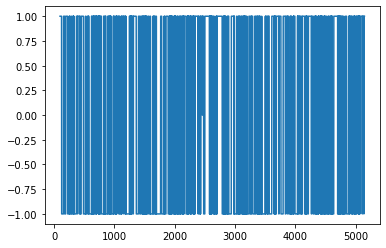

In [228]:
import matplotlib.pyplot as plt
plt.plot(y)

Classification accuracy:  0.6303630363036303


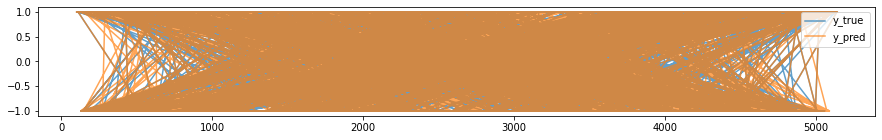

In [229]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
cf = XGBRegressor()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [230]:
from jellyfish.core import Strategy, Backtest


N_TRAIN = len(X_train)


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):
        # Init our model, a kNN classifier
        self.clf = XGBRegressor()

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_feed_data(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')
        self.confidences = self.I(lambda: np.repeat(np.nan, len(self.data)), name='confidence')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])

        # Update the plotted "forecast" indicator
        confidence = self.clf.predict(X)[0]
        forecast = 1 if confidence > 0 else -1
        self.confidences[-1] = abs(confidence)
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        if forecast == 1 and not self.position.is_long:
            self.buy()
        elif forecast == -1 and not self.position.is_short:
            self.sell()


bt = Backtest(frame, MLTrainOnceStrategy, cash=1e6)
stats = bt.run()
bt.plot()
stats

/tmp/ipykernel_9742/3997151841.py:53: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(frame, MLTrainOnceStrategy, cash=1e6)


Start                                   100.0
End                                    5167.0
Duration                               5067.0
Exposure Time [%]                   30.288082
Equity Final [$]                    236949.55
Equity Peak [$]                    1173721.44
Return [%]                         -76.305045
Buy & Hold Return [%]                  -5.328
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                        -0.685851
Sortino Ratio                       -0.463911
Calmar Ratio                        -0.433706
Max. Drawdown [%]                  -82.874911
Avg. Drawdown [%]                   -5.112796
Max. Drawdown Duration                 1132.0
Avg. Drawdown Duration              69.090909
# Trades                                244.0
Win Rate [%]                        51.639344
Best Trade [%]                      15.177415
Worst Trade [%]                    -78.213199
Avg. Trade [%]                    